
### Flood Fill

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import tictoc as t
import OIP20_lib_ImageProcessing_V4 as ip
import matplotlib.image as mpimg
import copy

def FloodFillLabeling(imgBIN, method='BF'):
    '''
    Algorithm 10.1
    Region marking by flood filling. 
    The binary input image I uses the value 0 for background pixels 
    and 1 for foreground pixels. Unmarked foreground pixels are searched for, 
    and then the region to which they belong is filled. 
    Procedure FloodFill() is defined in three different versions: recursive, depth-first and breadth-first.
    '''
    label = 2
    # collect the non-zero / foreground elements: 
    nzi = np.nonzero(imgBIN)
    FGu = nzi[0][:]
    FGv = nzi[1][:]
    print("Relevant foreground pixels: %i" %(FGu.shape[0]) )

    # make copy: 
    IMG = copy.deepcopy(imgBIN)

    # Flood fill loop: 
    for cnt, u in enumerate(FGu):
        v = FGv[cnt] 
        if (method == 'recursive'):       
            IMG = FloodFill_Recursive(IMG, u, v, label)
        elif (method == 'DF'):
            IMG = FloodFill_DF(IMG, u, v, label)
        elif (method == 'BF'):
            IMG = FloodFill_BF(IMG, u, v, label)
        else:
            print('ERROR: Method must be recursive, BF or DF!')
            break 
        label = label+1
    return IMG 

def FloodFill_Recursive(IMG, u, v, label):
    '''
    recursive version
    '''
    if u <= IMG.shape[0] and v <= IMG.shape[1] and  IMG[u,v] == 1:
            IMG[u,v] = label
            FloodFill_Recursive(IMG, u+1, v, label)
            FloodFill_Recursive(IMG, u, v+1, label)
            FloodFill_Recursive(IMG, u, v-1, label)
            FloodFill_Recursive(IMG, u-1, v, label)
    return IMG 



In [25]:
def FloodFill_DF(IMG, u, v, label):
    '''
    Depth-First Version (We treat lists as stacks)
    '''
    S = []
    S.insert(0,[u,v]) # 
    while S:  # While S is not empty...
        xy = S[0]
        x = xy[0]
        y = xy[1]
        S.pop(0)
        if x <= IMG.shape[0] and y <= IMG.shape[1] and  IMG[x,y] == 1:
            IMG[x,y] = label
            S.insert(0,[x+1, y])
            S.insert(0,[x, y+1])
            S.insert(0,[x,y-1])
            S.insert(0,[x-1,y])
    return IMG

def FloodFill_BF(IMG, u, v, label):
    '''
    Breadth-First Version (we treat lists as queues)
    '''
    S = []
    S.append([u,v])
    while S:  # While S is not empty...
        xy = S[0]
        x = xy[0]
        y = xy[1]
        S.pop(0)
        if x <= IMG.shape[0] and y <= IMG.shape[1] and  IMG[x,y] == 1:
            IMG[x,y] = label
            S.append([x+1, y])
            S.append([x, y+1])
            S.append([x,y-1])
            S.append([x-1,y])
    return IMG


Relevant foreground pixels: 24101
Relevant foreground pixels: 24101
Relevant foreground pixels: 24101


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1faa043eb88>)

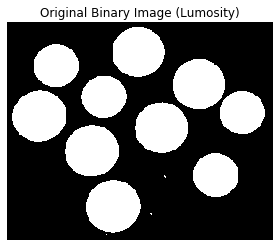

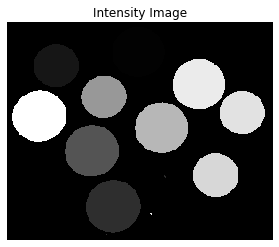

In [26]:
pics = ['Coins2.png',           #0           
        '1Coin.png',            #1
        '2Coins.png']           #2
                 
PicNUM = 0 # If you want to load an image, pick one of the above...
img = mpimg.imread(pics[PicNUM])
imgINT = (img*255).astype(np.uint8)#ip.convert2LUM(imgRED, imgGREEN, imgBLUE)
imgBIN = ip.threshold_binary(imgINT,80)
ip.plot_image(copy.deepcopy(imgBIN), title='Original Binary Image (Lumosity)', vmax = 1, vmin = 0)


A=FloodFillLabeling(imgBIN, method='BF')
A1=FloodFillLabeling(imgBIN, method='recursive')
A2=FloodFillLabeling(imgBIN, method='DF')
ip.plot_image(A,vmax = np.amax(A))



### Sequential Labeling 

In [27]:
def SequentialLabeling(imgBIN):
    '''
    Alg. 10.2: Sequential region labeling. 
    The binary input image I uses the value I(u, v) = 0 for background pixels 
    and I(u, v) = 1 for foreground (region) pixels. 
    The resulting labels have the values 2, . . . , label − 1.
    '''
    # make copy: 
    I = copy.deepcopy(imgBIN)
    
    # STEP 1 - ASSIGN INITIAL LABELS: 
    M, N = imgBIN.shape
    label = 2
    R = [] # Create the sequence of 1-element lists on the fly... 
    C = [] # List of label collisions 
    for v in range(N):
        for u in range(M):
            if I[u,v] == 1: 
                NVals = GetNeighbors8(I, u, v)
                if NVals: 
                    Num_N_Labeled = sum(i > 1 for i in NVals) # number of neighbors with a label > 1
                    Nmax = np.amax(NVals) # get the maximum label among the neighbors
                    if (Nmax == 0): 
                        I[u,v] = label
                        R.append([label])
                        label = label + 1
                    elif (Num_N_Labeled == 1):
                        I[u,v] = Nmax # set value to the (only) value > 1
                    elif (Num_N_Labeled > 1): 
                        I[u,v] = Nmax # set value to the heighest value > 1
                        for Nval in NVals:
                            if (Nval < Nmax) and (Nval > 1):
                                C.append([Nval,Nmax]) # register collision!
    # >>> THE IMAGE NOW CONTAINS LABELS 0, 2, ..., label-1
    #print(C)
    #print(R)
    # STEP 2 - RESOLVE LABEL COLLISIONS: 
    for collision in C:
        # print('collision:', collision)
        A = collision[0]
        B = collision[1]
        for idx, lbl in enumerate(R):
            # print('labels in R:', lbl)
            if A in lbl:
                idxA = idx
            if B in lbl:
                idxB = idx
        # print('idxA:', idxA)
        # print('idxB:', idxB)
        if idxA != idxB:
            R[idxA].extend(R[idxB]) # merge the two lists into one    
            R.pop(idxB) # remove the other one from the list of lists
            # print('new R:', R)
    # >>> NOW ALL EQUIVALENT LABELS ARE IN THE SAME LIST... 
    # print(R)

    # STEP 3 - Relabeling the image: 
    for u in range(M):
        for v in range(N):
            if (I[u,v] > 1): # If pixel is labeled: 
                for lbl in R:
                    if I[u,v] in lbl:         # Find set of equivalent labels  
                        I[u,v] = np.amin(lbl) # set label to minimum equivalent label
    print(len(R))
    return I 




In [28]:
def GetNeighbors4(I, u, v):
    neighborvals = []
    if u > 0:
        neighborvals.append(I[u-1,v])
    if v > 0:
        neighborvals.append(I[u,v-1])
    return neighborvals

def GetNeighbors8(I, u, v):
    neighborvals = []
    if (u > 0) and (v > 0):
        neighborvals.append(I[u-1,v])
        neighborvals.append(I[u-1,v-1])
        neighborvals.append(I[u,v-1])
        neighborvals.append(I[u+1,v-1])
    else:
        if u > 0: # then v == 0 
            neighborvals.append(I[u-1,v])   
        if v > 0: # then u == 0 
            neighborvals.append(I[u,v-1])
            neighborvals.append(I[u+1,v-1])
    return neighborvals

13
Elapsed time: 2.812118 seconds.



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1faa0499208>)

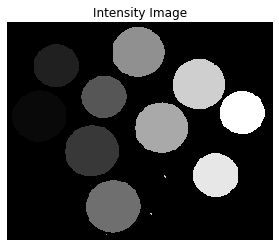

In [29]:
t.tic()
B=SequentialLabeling(imgBIN)
t.toc()
ip.plot_image(B,vmax = np.amax(B))


# Exercise 
   ### Distance transform 

In [30]:
def DistanceTransform(imgBIN, norm='L2'):
    '''
    Distance transform according to Burger, Burge 2016, Alg. 23.2
    Input: I, a, binary image; norm ∈ {"L1", "L2"}, distance function. 
    Returns the distance transform of I.
    '''
    # STEP 1 - INIT: 
    m1 = 1
    if norm == 'L1':
        m2 = 2
    elif norm == 'L2':
        m2 = np.sqrt(2)
    M, N = imgBIN.shape
    # Create a map D: M x N -> R
    D = (1-imgBIN).astype(np.float)
    D[D==0]=np.inf

    # STEP 2 - L -> R PASS: 
    for v in range(N):
        for u in range(M):
            if D[u,v] > 0:
                d1, d2, d3, d4 = np.inf, np.inf, np.inf, np.inf
                if u > 0:
                    d1 = m1+D[u-1,v]
                    if v > 0:
                        d2 = m2 + D[u-1,v-1]
                if v > 0:
                    d3 = m1 + D[u,v-1]
                    if u < M-1:
                        d4 = m2 + D[u+1,v-1]
                D[u,v] = np.amin([D[u,v], d1, d2, d3, d4])
    
    # STEP 3 - R -> L PASS: 
    for v in reversed(range(N)):
        for u in reversed(range(M)):
            if D[u,v] > 0:
                d1, d2, d3, d4 = np.inf, np.inf, np.inf, np.inf 
                if u < M-1:
                    d1 = m1+D[u+1,v]
                    if v < N-1:
                        d2 = m2 + D[u+1,v+1]
                if v < N-1:
                    d3 = m1 + D[u,v+1]
                    if u > 0:
                        d4 = m2 + D[u-1,v+1]
                D[u,v] = np.amin([D[u,v], d1, d2, d3, d4])
            
    return(D)

In [31]:
IMG_DIST = DistanceTransform(imgBIN)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1faa04ba448>)

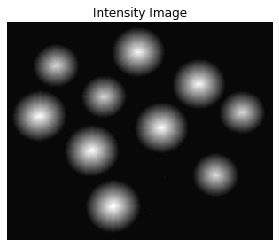

In [32]:
ip.plot_image(IMG_DIST,vmax = np.amax(IMG_DIST))

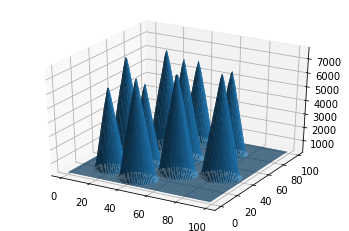

In [33]:
from skimage.transform import resize
ID = resize(IMG_DIST, (100, 100))*255

# Plot the distance maps as surfaces: 
from mpl_toolkits.mplot3d import Axes3D

xx, yy = np.mgrid[0:ID.shape[0], 0:ID.shape[1]]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, ID ,rstride=1, cstride=1,# cmap=plt.cm.gray,
        linewidth=0)

# show it
plt.show()